## For the demo, we shall implement four inference tasks on an HMM : filtering, prediction, smoothing, and computation of the most likely sequence (the viterbi algorithm) for the weather example as covered in the lecture videos.

## Exploratory Data Analysis

In [0]:
import pandas as pd

In [0]:
def loadData(filename):
   input = open(filename, 'r')
   input.readline()
   data = []
   for i in input.readlines():
      x = i.split()
      y = x[0].split(",")
      data.append(y)
   return data

In [0]:
filename = 'weather-1000.txt'
data = loadData(filename)

In [0]:
observations = []
classes = []

for c,o in data:
    observations.append(o)
    classes.append(c)

**Distribution of classes**

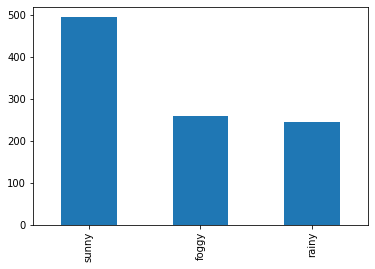

In [0]:
pd.Series(classes).value_counts().plot(kind='bar')

**Distribution of observations**

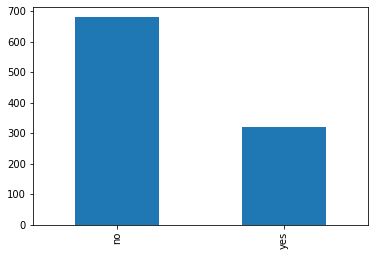

In [0]:
pd.Series(observations).value_counts().plot(kind='bar')

In [0]:
df = pd.DataFrame({'classes':classes,'observations':observations})
df.groupby(['classes','observations'])['observations'].count()

classes  observations
foggy    no              181
         yes              79
rainy    no               46
         yes             199
sunny    no              452
         yes              42
Name: observations, dtype: int64


For sunny, we see most of the times there are no umbrella

For rainy, we see the majority of the time there are umbrellas

For foggy, there are more days we see no umbrella than days we see there are.

## Initials provided

### State map


In [0]:
weatherStateMap   = {'sunny' : 0, 'rainy' : 1, 'foggy' : 2}
weatherStateIndex = {0 : 'sunny', 1 : 'rainy', 2 : 'foggy'}

### Observation map


In [0]:
weatherObsMap   = {'no' : 0, 'yes' : 1}
weatherObsIndex = {0 : 'no', 1 : 'yes'}

### prior probability on weather states

    P(sunny) = 0.5  
    P(rainy) = 0.25  
    P(foggy) = 0.25

In [0]:
weatherProb = [0.5, 0.25, 0.25]

### transition probabilities
                    
            tomorrrow
    today     sunny  rainy  foggy
    sunny      0.8    0.05   0.15
    rainy      0.2    0.6    0.2 
    foggy      0.2    0.3    0.5

In [0]:
weatherTProb = [ [0.8, 0.05, 0.15], [0.2, 0.6, 0.2], [0.2, 0.3, 0.5] ]


### conditional probabilities of evidence (observations) given weather
                         
            Probs            sunny  rainy  foggy 
    P(umbrella=no|weather)      0.9    0.2    0.7
 
    P(umbrella=yes|weather)     0.1    0.8    0.3

In [0]:
weatherEProb = [[0.9, 0.2, 0.7], [0.1, 0.8, 0.3]]

## Helper Functions

### Using the prior probabilities and state map, return:
     
     P(state)

In [0]:
def getStatePriorProb(prob, stateMap, state):
   return prob[stateMap[state]]

### Using the transition probabilities and state map, return:
     
     P(next state | current state)


In [0]:
def getNextStateProb(tprob, stateMap, current, next):
   return tprob[stateMap[current]][stateMap[next]]


### Using the observation probabilities, state map, and observation map, return:
     P(observation | state)


In [0]:
def getObservationProb(eprob, stateMap, obsMap, state, obs):
   return eprob[obsMap[obs]][stateMap[state]]

### Normalize a probability distribution


In [0]:
def normalize(pdist):
   s = sum(pdist)
   for i in range(0,len(pdist)):
      pdist[i] = pdist[i] / s
   return pdist

## HMM Inference

**Let's consider a short observation sequence of 5 days**

In [0]:
n_obs_short = 5

obs_short = observations[0:n_obs_short]
classes_short = classes[0:n_obs_short]
print('Short observation sequence:')
print('   ', obs_short)

Short observation sequence:
    ['no', 'no', 'yes', 'no', 'no']


Text(0, 0.5, 'Weather')

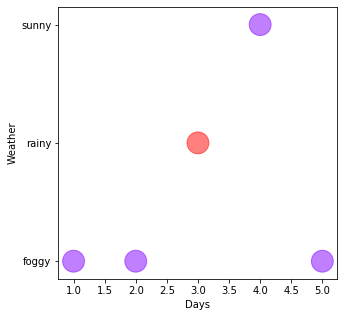

In [0]:
import matplotlib
from matplotlib import cm, pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(5,5)) 
fig1 = fig.add_subplot(111)
fig1.scatter(range(1,len(classes_short)+1), classes_short, s=480, c=[weatherObsMap[i] for i in obs_short], alpha=0.5, cmap=plt.cm.rainbow)
fig1.set_xlabel('Days')
fig1.set_ylabel('Weather')

### Filtering.

Input:  The HMM (state and observation maps, and probabilities) 
         A list of T observations: E(0), E(1), ..., E(T-1)
         (ie whether the umbrella was seen [yes, no, ...])

Output: The posterior probability distribution over the most recent state
         given all of the observations: P(X(T-1)|E(0), ..., E(T-1)).

In [0]:
def filter(stateMap, stateIndex, obsMap, obsIndex, prob, tprob, eprob, observations):
   # intialize probability distribution to prior
   pdist = prob
   # update for subsequent times 
   for k in range(0,len(observations)):
      pdist_new = []
      for i in range(0,len(stateMap)):
         prob_i = 0.0
         for j in range(0,len(stateMap)):
            prob_i = prob_i + tprob[j][i] * pdist[j]
         prob_i = prob_i * eprob[obsMap[observations[k]]][i]
         pdist_new.append(prob_i)
      pdist = normalize(pdist_new)
   return pdist

In [0]:
result_filter = filter(weatherStateMap,weatherStateIndex, weatherObsMap, weatherObsIndex, weatherProb, weatherTProb, weatherEProb, obs_short)

print('\nFiltering - distribution over most recent state:')
for i in range(0,len(result_filter)):
    print('   ', weatherStateIndex[i], '%1.3f' % result_filter[i])


Filtering - distribution over most recent state:
    sunny 0.676
    rainy 0.057
    foggy 0.268


### Prediction.

Input:  The HMM (state and observation maps, and probabilities) 
         A list of T observations: E(0), E(1), ..., E(T-1)

Output: The posterior probability distribution over the next state
         given all of the observations: P(X(T)|E(0), ..., E(T-1)).

In [0]:
def predict(stateMap, stateIndex, obsMap, obsIndex, prob, tprob, eprob, observations):
   
   # compute P(X(T-1)|E(0), ..., E(T-1))
   pdist = filter(stateMap, stateIndex, obsMap, obsIndex, prob, tprob, eprob, observations)
   
   # predict next timestep
   pdist_next = []
   for i in range(0,len(stateMap)):
      prob_i = 0.0
      for j in range(0,len(stateMap)):
         prob_i = prob_i + tprob[j][i] * pdist[j]
      pdist_next.append(prob_i)
   return pdist_next

In [0]:
result_predict = predict(weatherStateMap,weatherStateIndex, weatherObsMap, weatherObsIndex, weatherProb, weatherTProb, weatherEProb, obs_short)

print('\n\nPrediction - distribution over next state:')
for i in range(0,len(result_filter)):
    print('   ', weatherStateIndex[i], '%1.3f' % result_predict[i])



Prediction - distribution over next state:
    sunny 0.605
    rainy 0.148
    foggy 0.247


### Smoothing.
Input:  The HMM (state and observation maps, and probabilities) 
         A list of T observations: E(0), E(1), ..., E(T-1)

Ouptut: The posterior probability distribution over each state given all
         of the observations: P(X(k)|E(0), ..., E(T-1) for 0 <= k <= T-1. 

These distributions should be returned as a list of lists. 

In [0]:
def smooth(stateMap, stateIndex, obsMap, obsIndex, prob, tprob, eprob, observations):
   # compute forward messages
   fv = prob
   forward = []
   for k in range(0,len(observations)):
      fv_next = []
      for i in range(0,len(stateMap)):
         prob_i = 0.0
         for j in range(0,len(stateMap)):
            prob_i = prob_i + tprob[j][i] * fv[j]
         prob_i = prob_i * eprob[obsMap[observations[k]]][i]
         fv_next.append(prob_i)
      fv = normalize(fv_next)
      forward.append(fv)
   # compute backward messages
   sv = []
   b = []
   for i in range(0,len(stateMap)):
      b.append(1)
   for k in range(len(observations)-1,-1,-1):
      sv_curr = []
      for i in range(0,len(stateMap)):
         sv_curr.append(forward[k][i]*b[i])
      sv.append(normalize(sv_curr))
      b_prev = []
      for i in range(0,len(stateMap)):
         prob_i = 0.0
         for j in range(0,len(stateMap)):
            prob_i = \
               prob_i + eprob[obsMap[observations[k]]][j] * b[j] * tprob[i][j]
         b_prev.append(prob_i)
      b = normalize(b_prev)
   sv.reverse()
   return sv

In [0]:
result_smooth = smooth(weatherStateMap,weatherStateIndex, weatherObsMap, weatherObsIndex, weatherProb, weatherTProb, weatherEProb, obs_short)
print('\n\nSmoothing - distribution over state at each point in time:')

for t in range(0,len(result_smooth)):
    result_t = result_smooth[t]
    print('   ', 'time', t)
    for i in range(0,len(result_t)):
        print('   ', weatherStateIndex[i], '%1.3f' % result_t[i])
    print(' ')



Smoothing - distribution over state at each point in time:
    time 0
    sunny 0.684
    rainy 0.055
    foggy 0.261
 
    time 1
    sunny 0.602
    rainy 0.073
    foggy 0.324
 
    time 2
    sunny 0.429
    rainy 0.301
    foggy 0.270
 
    time 3
    sunny 0.650
    rainy 0.077
    foggy 0.272
 
    time 4
    sunny 0.676
    rainy 0.057
    foggy 0.268
 


### Viterbi algorithm.

Input:  The HMM (state and observation maps, and probabilities) 
         A list of T observations: E(0), E(1), ..., E(T-1)
      
Output: A list containing the most likely sequence of states. (ie [sunny, foggy, rainy, sunny, ...])

In [0]:
def viterbi(stateMap, stateIndex, obsMap, obsIndex, prob, tprob, eprob, observations):
   # intialize probability distribution to prior
   pdist = prob
   
   # update max probability paths, keeping back links to best path
   back_pointers = []
   for k in range(0,len(observations)):
      pdist_new = []
      prev_pointer = []
      for i in range(0,len(stateMap)):
         prob_i = 0.0
         best_j = 0
         for j in range(0,len(stateMap)):
            prob_i_from_j = tprob[j][i] * pdist[j]
            if (prob_i_from_j > prob_i):
               prob_i = prob_i_from_j
               best_j = j
         prob_i = prob_i * eprob[obsMap[observations[k]]][i]
         pdist_new.append(prob_i)
         prev_pointer.append(best_j)
      pdist = normalize(pdist_new)
      back_pointers.append(prev_pointer)
   # extract the best path
   n = len(observations) - 1
   s_prob = 0
   s = 0
   for i in range(0,len(stateMap)):
      if (pdist[i] > s_prob):
         s_prob = pdist[i]
         s = i
   seq = []
   for k in range(n,-1,-1):
      seq.append(stateIndex[s])
      s = back_pointers[k][s]
   seq.reverse()
   return seq

In [0]:
result_viterbi = viterbi(weatherStateMap, weatherStateIndex, weatherObsMap, weatherObsIndex, weatherProb, weatherTProb, weatherEProb, obs_short)
print('\nViterbi - predicted state sequence:\n   ', result_viterbi)
print('Viterbi - actual state sequence:\n   ', classes_short)


Viterbi - predicted state sequence:
    ['sunny', 'sunny', 'sunny', 'sunny', 'sunny']
Viterbi - actual state sequence:
    ['foggy', 'foggy', 'rainy', 'sunny', 'foggy']


**Accuracy**

In [0]:
def accuracy(a,b):
   total = float(max(len(a),len(b)))
   c = 0
   for i in range(min(len(a),len(b))):
      if a[i] == b[i]:
         c = c + 1          
   return c/total

In [0]:
print('The accuracy of your viterbi classifier on the short data set is', accuracy(classes_short, result_viterbi))

The accuracy of your viterbi classifier on the short data set is 0.2


In [0]:
result_viterbi_full = viterbi( weatherStateMap,weatherStateIndex, weatherObsMap, weatherObsIndex,
                              weatherProb, weatherTProb, weatherEProb, observations)
print('The accuracy of your viterbi classifier on the entire data set is', accuracy(classes, result_viterbi_full))

The accuracy of your viterbi classifier on the entire data set is 0.6366366366366366


# Assignment

**Short Assignment : As you can observe that results are very poor, let's increase the short observation sequence 'n_obs_short' to  10, run the whole notebook again. Do you get a better result?**